In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm 
import plotly.express as px

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
df = pd.read_csv('/content/AAPL.csv')
df.head()

,Date,Close,Volume,Open,High,Low
0,2010-06-03,37.5886,162341809,37.8828,37.9357,37.2014
1,2010-06-04,36.5664,189045767,36.8871,37.4143,36.3757
2,2010-06-07,35.8486,221253336,36.8986,37.0214,35.7928
3,2010-06-08,35.6186,249904415,36.1771,36.2571,35.0928
4,2010-06-09,34.7428,213040094,35.9243,35.9857,34.6414


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2517 non-null   datetime64[ns]
 1   Close   2517 non-null   float64       
 2   Volume  2517 non-null   int64         
 3   Open    2517 non-null   float64       
 4   High    2517 non-null   float64       
 5   Low     2517 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 118.1 KB


In [ ]:
df = df[['Date', 'Close']]
df.head()

,Date,Close
0,2010-06-03,37.5886
1,2010-06-04,36.5664
2,2010-06-07,35.8486
3,2010-06-08,35.6186
4,2010-06-09,34.7428


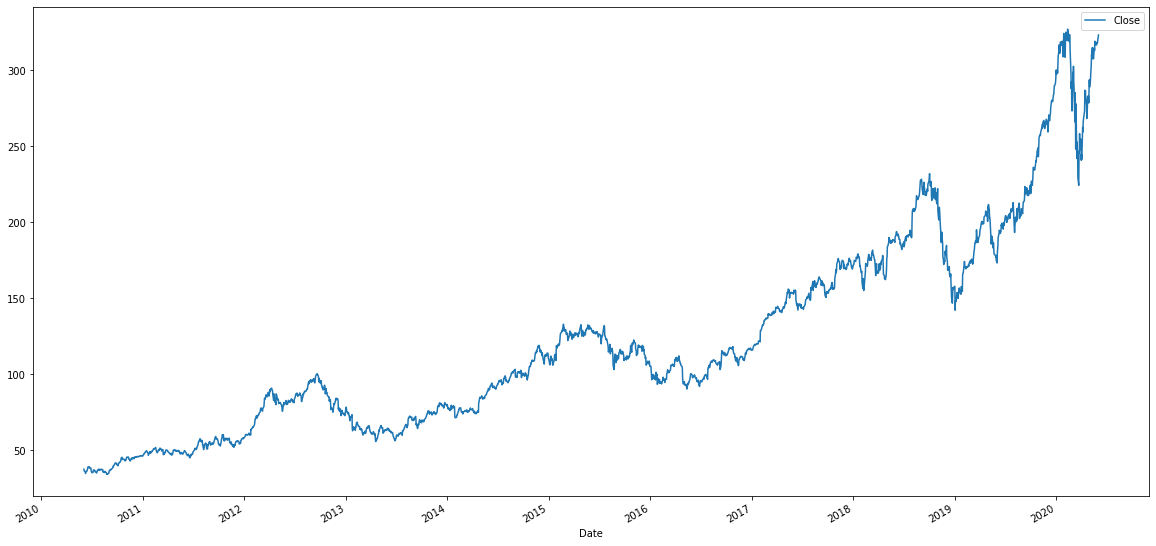

In [ ]:
df.plot(x='Date', y='Close', figsize=(20,10))

In [ ]:
def ilinechart(df, x, y, groups=None, title=''):
    fig = px.line(df, x=x, y=y, color=groups, title=title, 
                  template='none')

    fig.show()

In [ ]:
ilinechart(df, 'Date', 'Close', title='Observations over time')

In [ ]:
series = df.set_index('Date')
decomposition = sm.tsa.seasonal_decompose(series, model='additive', freq=252)

decomposition

In [ ]:
trend = decomposition.trend.reset_index()
seasonality = decomposition.seasonal.reset_index()
residuals = decomposition.resid.reset_index()

In [ ]:
merged = df.merge(trend, on='Date')
merged = merged.merge(seasonality, on='Date')
merged = merged.merge(residuals, on='Date')
merged.columns = ['Date', 'Observed', 'Trend', 'Seasonality', 'Residuals']
merged.head()

,Date,Observed,Trend,Seasonality,Residuals
0,2010-06-03,37.5886,NaN,0.966307,NaN
1,2010-06-04,36.5664,NaN,1.008828,NaN
2,2010-06-07,35.8486,NaN,0.976376,NaN
3,2010-06-08,35.6186,NaN,0.387145,NaN
4,2010-06-09,34.7428,NaN,-0.174811,NaN


In [ ]:
ilinechart(merged, 'Date', 'Residuals')

In [ ]:
merged['T+S'] = merged['Trend'] + merged['Seasonality']

In [ ]:
melted = pd.melt(merged, 
                 id_vars='Date', 
                 value_vars=['Observed', 'Trend', 'Seasonality', 'T+S', 'Residuals'])

melted.head()

,Date,variable,value
0,2010-06-03,Observed,37.5886
1,2010-06-04,Observed,36.5664
2,2010-06-07,Observed,35.8486
3,2010-06-08,Observed,35.6186
4,2010-06-09,Observed,34.7428


In [ ]:
melted['variable'].unique()

array(['Observed', 'Trend', 'Seasonality', 'T+S', 'Residuals'],
      dtype=object)

In [ ]:
ilinechart(melted, 'Date', 'value', groups='variable', title='Observed vs. Components')

In [ ]:
df.head(100)

,Date,Close
0,2010-06-03,37.5886
1,2010-06-04,36.5664
2,2010-06-07,35.8486
3,2010-06-08,35.6186
4,2010-06-09,34.7428
...,...,...
95,2010-10-18,45.4286
96,2010-10-19,44.2128
97,2010-10-20,44.3614
98,2010-10-21,44.2171


In [ ]:
merged['Rolling_Mean'] = merged['Observed'].rolling(window=252).mean()
merged['Rolling_Std'] = merged['Observed'].rolling(window=252).std()

In [ ]:
melted = pd.melt(merged, id_vars='Date', value_vars=['Observed', 'Rolling_Mean', 'Rolling_Std'])

ilinechart(melted, 'Date', 'value', groups='variable', title='Rolling Mean & Standard Deviation')

In [ ]:
adf_test = sm.tsa.stattools.adfuller(merged['Observed'])
results = pd.Series(adf_test[0:4], index=['ADF Test Statistic', 'P-Value', '# Lags Used', '# Observations Used'])

for key, value in adf_test[4].items():
  results[f'Critical Value {key}'] = value

results

ADF Test Statistic        0.635207
P-Value                   0.988452
# Lags Used              26.000000
# Observations Used    2490.000000
Critical Value 1%        -3.432979
Critical Value 5%        -2.862701
Critical Value 10%       -2.567388
dtype: float64

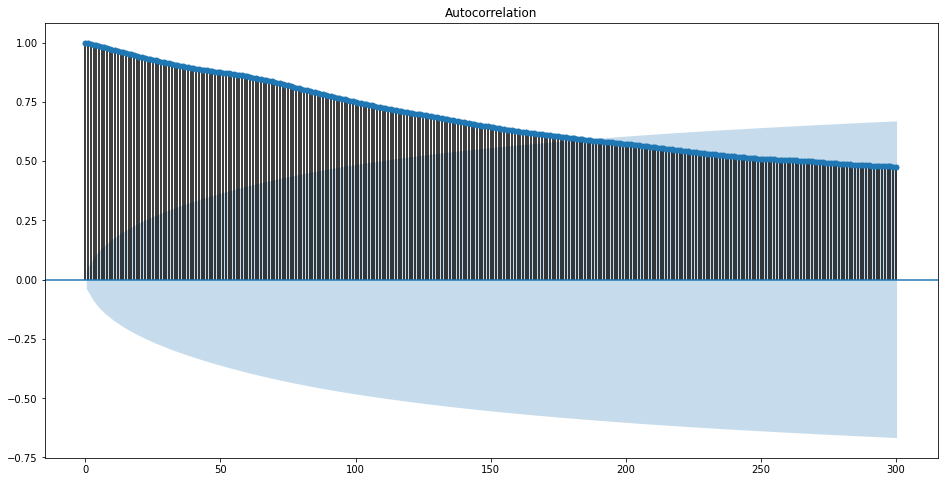

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from pylab import rcParams
rcParams['figure.figsize'] = 16,8

series = df.set_index('Date')
fig = plot_acf(series, lags=300)